# Working with Lightkurve objects examples

This notebook shows how to obtain light curves via the lightkurve python package. Lightkurve objects are used in combination with TCEs as input to exovetter's vetting algorithms. For more on lightkurve (including how to create custom lightkurve objects) see https://docs.lightkurve.org/index.html

In [1]:
import lightkurve as lk
from exovetter import utils
from exovetter.tce import Tce
from exovetter import const as exo_const
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Searching and downloading light curves

We can use lightkurve's `search_lightcurve()` function to find light curves stored in MAST and download them for use in exovetter. Here, like in the final TCE examples, we pull down TESS light curves of the known planet WASP-18 b.

In [2]:
lk_search = lk.search_lightcurve(target = 'WASP-18 b', mission = "TESS")
lk_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 02,2018,QLP,1800,100100827,0.0
3,TESS Sector 02,2018,TASOC,120,100100827,0.0
4,TESS Sector 02,2018,TASOC,1800,100100827,0.0
5,TESS Sector 02,2018,GSFC-ELEANOR-LITE,1800,100100827,0.0
...,...,...,...,...,...,...
21,TESS Sector 30,2020,SPOC,20,100100827,0.0
22,TESS Sector 30,2020,SPOC,120,100100827,0.0


From this list of results we download one of them, in this case a SPOC FFI light curve which was the first result returned.

In [3]:
lcf = lk_search[0].download()  
lcf

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1354.1115072617192,4.7745688e+04,2.5922741e+01,3.2845002e-03,91190,1638.57401,468.04924,4.5699730e+04,2.4585836e+01,2.1270193e+03,7.5499601e+00,4.7745688e+04,2.5922741e+01,0,———,———,———,———,1638.57401,5.5316015e-04,468.04924,5.7710981e-04,-1.2000147e-01,7.8144908e-02
1354.1128961919705,4.7782176e+04,2.5922379e+01,3.2845421e-03,91191,1638.58778,468.04160,4.5753094e+04,2.4585493e+01,2.1165220e+03,7.5075278e+00,4.7782176e+04,2.5922379e+01,0,———,———,———,———,1638.58778,5.5368309e-04,468.04160,5.7716778e-04,-1.0294508e-01,6.7404680e-02
1354.1142851224547,4.7737035e+04,2.5922800e+01,3.2845843e-03,91192,1638.58725,468.03821,4.5719250e+04,2.4585894e+01,2.1220544e+03,7.5287137e+00,4.7737035e+04,2.5922800e+01,0,———,———,———,———,1638.58725,5.5385107e-04,468.03821,5.7766296e-04,-1.0323820e-01,6.3302755e-02
1354.117062983188,4.7739652e+04,2.5921152e+01,3.2846683e-03,91194,1638.58337,468.02563,4.5696863e+04,2.4584332e+01,2.1406106e+03,7.5460734e+00,4.7739652e+04,2.5921152e+01,0,———,———,———,———,1638.58337,5.5345549e-04,468.02563,5.7999988e-04,-1.0774896e-01,5.0843615e-02
1354.1184519134392,4.7759828e+04,2.5928436e+01,3.2847102e-03,91195,1638.59648,468.05560,4.5737141e+04,2.4591240e+01,2.1321707e+03,7.5400863e+00,4.7759828e+04,2.5928436e+01,0,———,———,———,———,1638.59648,5.5386929e-04,468.05560,5.7663023e-04,-9.3161479e-02,8.3432972e-02
1354.1198408439234,4.7727695e+04,2.5917774e+01,3.2847524e-03,91196,1638.59691,468.04240,4.5714668e+04,2.4581129e+01,2.1199805e+03,7.5265331e+00,4.7727695e+04,2.5917774e+01,0,———,———,———,———,1638.59691,5.5403763e-04,468.04240,5.7726464e-04,-9.2094876e-02,6.8144821e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381.510514525368,4.7724891e+04,2.6401802e+01,3.6914796e-03,110917,1638.68105,467.98689,4.5899270e+04,2.5040192e+01,2.8671475e+03,8.3084249e+00,4.7724891e+04,2.6401802e+01,0,———,———,———,———,1638.68105,5.6833116e-04,467.98689,5.8781775e-04,1.2774169e-02,5.1160059e-03


## Cleaning and flattening light curves

In order to use a light curve in exovetter it is recommended to remove nans and outliers from the flux and then flatten the light curve. To flatten we mask out actual transit then apply filter, which requires some information stored in the TCE of the light curve's TOI.

In [4]:
tce = Tce.from_json('wasp18b_tce') # Open the TCE we made in the TCEs notebook
display(tce)

{'period': <Quantity 0.94145223 d>,
 'epoch': <Quantity 58374.669883 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.00931894>,
 'duration': <Quantity 0.08932 d>,
 'snr': 50,
 'event_name': 'WASP-18 b',
 'target_name': 'WASP-18'}

The `transit_mask` method from lightkurve accepts the epoch, period, and duration of the transit. Note to convert the epoch of the transit into the time system used in the lightkurve file (BTJD) we use the `get_epoch` method from `exovetter.Tce`.

In [5]:
epoch = Tce.get_epoch(tce, offset = exo_const.btjd)
period = tce['period']
duration = tce['duration']

Without any modifications the light curve looks like this:

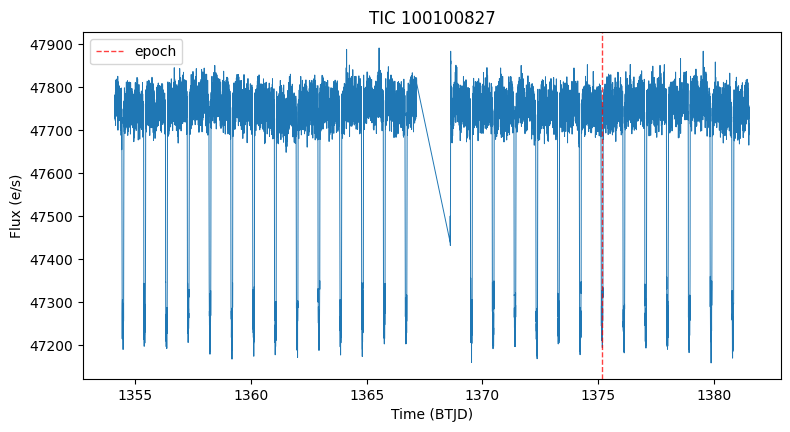

In [6]:
plt.figure(figsize=(9,4.5))
plt.plot(lcf.time.value, lcf.flux.value, lw=0.7)
plt.axvline(x=epoch.value, color='red', lw=1, ls='--', alpha=0.75, label='epoch')
plt.legend()
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux (e/s)')
plt.title(lcf.meta['OBJECT'])
plt.show()

We can now remove nans, outliers, and flatten the light curve:

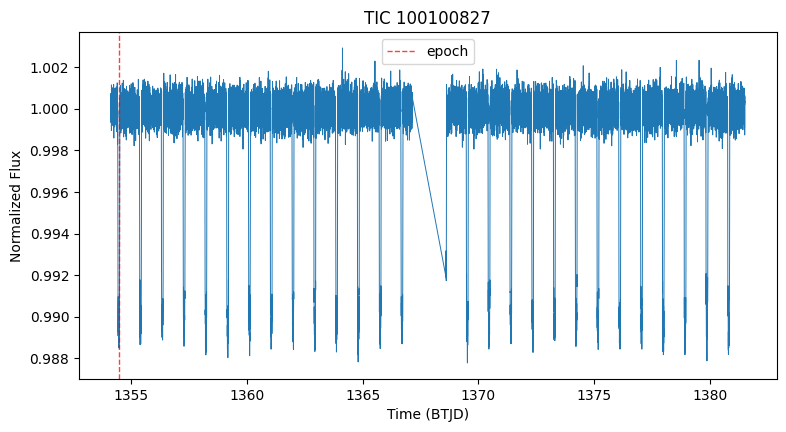

In [7]:
# Remove NaNs and outliers
lcf = lcf[~np.isnan(lcf["flux"])]
lcf = lcf.remove_outliers(sigma_lower=8, sigma_upper=4)

# We can redefine the epoch as the first transit in this lightkurve using exovetter.utils.assert_epoch() 
# In practice the transit_mask works with an epoch of any transit in the lightkurve 
first_epoch = utils.first_epoch(epoch, period, lcf)

# Flatten the light curve by masking out the transit and apply a filter to the rest of the data
transit_mask = lcf.create_transit_mask(transit_time=first_epoch, period=period, duration=duration)
lc_flat = lcf.flatten(mask=transit_mask)

# Plot the now flattened light curve
plt.figure(figsize=(9,4.5))
plt.plot(lc_flat.time.value, lc_flat.flux.value, lw=0.7)
plt.axvline(x=first_epoch.value, color='red', lw=1, ls='--', alpha=0.75, label='epoch')
plt.legend()
plt.xlabel('Time (BTJD)')
plt.ylabel('Normalized Flux')
plt.title(lcf.meta['OBJECT'])
plt.show()

## Saving, editing, and opening a lightkurve object as a fits file

In order to save a lightkurve for later use after editing we can use the `to_fits` method.

In [8]:
lc_flat.to_fits(path="./wasp18b.fits", overwrite=True)

The `to_fits` method automatically fills in the flux column units label as e/s. The flux column of our input flattened light curve was normalized so here we show how to open and edit lightkurve fits files in order to change the flux column units definition. 

In [9]:
with fits.open("./wasp18b.fits", mode='update', memmap=False) as hdul:
    hdul[1].header['TUNIT2'] = ''
    hdul[1].header['TUNIT3'] = ''

The light curve fits file can now be opened and used using the `lightkurve.read` method.

<Figure size 640x480 with 0 Axes>

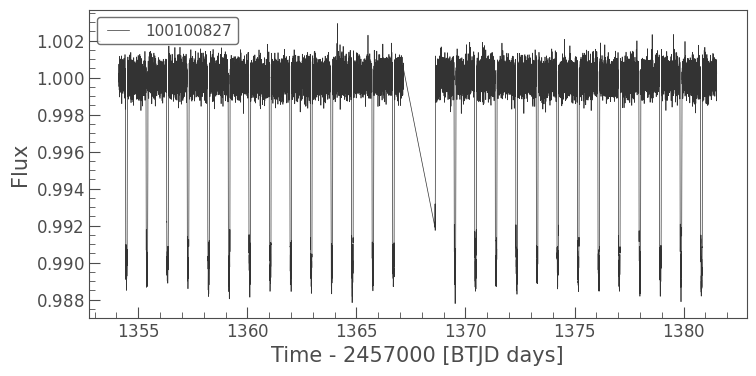

In [10]:
lc = lk.read("./wasp18b.fits", flux_column='flux')

# The built in plot method can be used to quickly visualize a lightkurve
plt.figure()
lc.plot()
plt.show()